In [13]:
from regelum.environment.node.base import Node, State, Inputs, Graph, MPCNodeFactory
import numpy as np
from regelum.utils import rg
import logging
from typing import Dict, Any
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Dict, Any
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from regelum.utils import rg
from stable_baselines3.common.buffers import ReplayBuffer
import gymnasium as gym
import torch.optim as optim
from typing import Optional
from IPython.display import display, clear_output
import os

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)


## Pendulum PD controller

# ![Pendulum PD Controller|width=3.67%](./gfx/pd.png)


In [14]:
class Pendulum(Node):
    state = State("pendulum_state", (2,), np.array([np.pi, 0]))
    inputs = Inputs(["pendulum_pd_control", "reset_pendulum_state"])
    length = 1
    mass = 1
    gravity_acceleration = 9.81

    def system_dynamics(self, x, u):
        pendulum_mpc_control = u

        angle = x[0]
        angular_velocity = x[1]
        torque = pendulum_mpc_control

        d_angle = angular_velocity
        d_angular_velocity = self.gravity_acceleration / (self.length) * rg.sin(
            angle
        ) + torque / (self.mass * self.length**2)

        return {"pendulum_state": rg.vstack([d_angle, d_angular_velocity])}

    def compute_state_dynamics(self):
        pendulum_mpc_control = self.inputs["pendulum_pd_control"].data

        return self.system_dynamics(self.state.data, pendulum_mpc_control)


In [15]:
class PendulumPDController(Node):
    state = State("pendulum_pd_control", (1,))
    inputs = Inputs(["pendulum_state"])

    def __init__(self, kp: float = 0.01, kd: float = 0.01, step_size: float = 0.01):
        super().__init__(step_size=step_size)
        self.kp = kp
        self.kd = kd

    def compute_state_dynamics(self):
        pendulum_state = self.inputs["pendulum_state"].data

        angle = pendulum_state[0]
        angular_velocity = pendulum_state[1]

        return {"pendulum_pd_control": -self.kp * angle - self.kd * angular_velocity}

In [16]:
class IsTruncated(Node):
    def __init__(self, steps_to_truncate: int, **kwargs):
        state = State("is_truncated", (1,), False)
        inputs = ["step_counter"]
        self.steps_to_truncate = steps_to_truncate
        super().__init__(state=state, inputs=inputs, **kwargs)

    def compute_state_dynamics(self) -> Dict[str, Any]:
        residual = self.inputs["step_counter"].data[0] % self.steps_to_truncate
        return {self.state.name: residual == 0}


class Reset(Node):
    def __init__(self, input_node: Node, **kwargs):
        state = State(f"reset_{input_node.state.name}", (1,), False)
        inputs = ["is_truncated"]
        super().__init__(state=state, inputs=inputs, **kwargs)

    def compute_state_dynamics(self) -> Dict[str, Any]:
        return {self.state.name: self.inputs["is_truncated"].data}

In [17]:
class PlotDumper(Node):
    def __init__(self, **kwargs):
        state = State("plot_dumper", (1,), False)
        inputs = ["pendulum_state", "pendulum_pd_control", "reset_pendulum_state"]
        super().__init__(state=state, inputs=inputs, **kwargs)
        self.states = []
        self.controls = []

    def compute_state_dynamics(self) -> Dict[str, Any]:
        self.states.append(self.inputs["pendulum_state"].data)
        self.controls.append(self.inputs["pendulum_pd_control"].data)

        if self.inputs["reset_pendulum_state"].data:
            self._plot()
            self.states = []
            self.controls = []

        return {self.state.name: False}

    def _plot(self) -> None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        states = np.array(self.states)
        controls = np.array(self.controls)
        times = np.arange(len(states)) * self.step_size

        ax1.plot(times, states[:, 0], label="angle")
        ax1.plot(times, states[:, 1], label="angular velocity")
        ax1.set_ylabel("State")
        ax1.legend()

        ax2.plot(times, controls, label="control")
        ax2.set_xlabel("Time [s]")
        ax2.set_ylabel("Control")
        ax2.legend()

        plt.show()

In [18]:
n_steps = 1000
pd_controller = PendulumPDController(20, 20, step_size=0.01)
pendulum = Pendulum(is_root=True, is_continuous=True)
is_truncated = IsTruncated(steps_to_truncate=1000)
reset = Reset(pendulum)
plot_dumper = PlotDumper()
graph = Graph(
    [pd_controller, pendulum, is_truncated, reset, plot_dumper],
    states_to_log=["pendulum_state", "pendulum_pd_control"],
    logger_cooldown=0.5
)

Resolved node order: pendulum_state -> Clock -> step_counter -> pendulum_pd_control -> is_truncated -> reset_pendulum_state -> Logger -> plot_dumper


2024-12-04 13:56:02,368 - t=0.110 | pendulum_state=[3.142 0.   ] | pendulum_pd_control=-62.832
2024-12-04 13:56:02,425 - t=0.610 | pendulum_state=[ 2.044 -1.721] | pendulum_pd_control=-6.469
2024-12-04 13:56:02,476 - t=1.110 | pendulum_state=[ 1.401 -0.965] | pendulum_pd_control=-8.711
2024-12-04 13:56:02,526 - t=1.610 | pendulum_state=[ 1.013 -0.622] | pendulum_pd_control=-7.822
2024-12-04 13:56:02,591 - t=2.120 | pendulum_state=[ 0.749 -0.43 ] | pendulum_pd_control=-6.378
2024-12-04 13:56:02,642 - t=2.630 | pendulum_state=[ 0.562 -0.311] | pendulum_pd_control=-5.029
2024-12-04 13:56:02,696 - t=3.140 | pendulum_state=[ 0.426 -0.23 ] | pendulum_pd_control=-3.909
2024-12-04 13:56:02,749 - t=3.650 | pendulum_state=[ 0.324 -0.173] | pendulum_pd_control=-3.017
2024-12-04 13:56:02,792 - t=4.160 | pendulum_state=[ 0.247 -0.131] | pendulum_pd_control=-2.320
2024-12-04 13:56:02,848 - t=4.670 | pendulum_state=[ 0.188 -0.099] | pendulum_pd_control=-1.780
2024-12-04 13:56:02,893 - t=5.180 | pendu

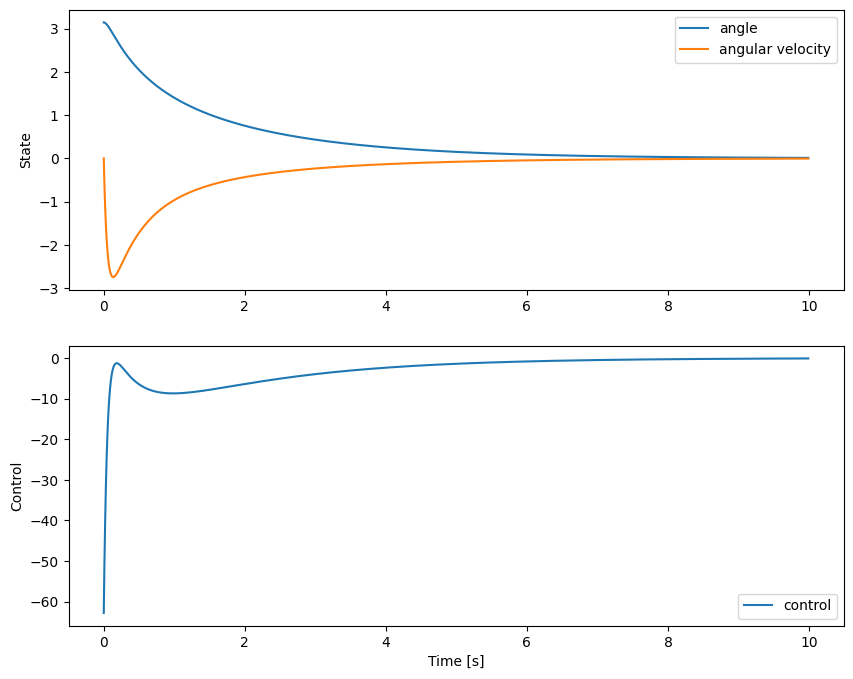

In [19]:
for _ in range(n_steps):
    graph.step()

graph.reset()

## MPC controller

In [20]:
class Pendulum(Node):
    state = State("pendulum_state", (2,), np.array([np.pi, 0]))
    inputs = Inputs(["mpc_pendulum_state_control", "reset_pendulum_state"])
    length = 1
    mass = 1
    gravity_acceleration = 9.81

    def system_dynamics(self, x, u):
        pendulum_mpc_control = u

        angle = x[0]
        angular_velocity = x[1]
        torque = pendulum_mpc_control

        d_angle = angular_velocity
        d_angular_velocity = (
            -3 * self.gravity_acceleration / (2 * self.length) * rg.sin(angle)
            + torque / self.mass
        )

        return {"pendulum_state": rg.vstack([d_angle, d_angular_velocity])}

    def compute_state_dynamics(self):
        pendulum_mpc_control = self.inputs["mpc_pendulum_state_control"].data

        return self.system_dynamics(self.state.data, pendulum_mpc_control)
    



In [21]:
class IsTruncated(Node):
    def __init__(self, steps_to_truncate: int, **kwargs):
        state = State("is_truncated", (1,), False)
        inputs = ["step_counter"]
        self.steps_to_truncate = steps_to_truncate
        super().__init__(state=state, inputs=inputs, **kwargs)

    def compute_state_dynamics(self) -> Dict[str, Any]:
        residual = self.inputs["step_counter"].data[0] % self.steps_to_truncate
        return {self.state.name: residual == 0}


class Reset(Node):
    def __init__(self, input_node: Node, **kwargs):
        state = State(f"reset_{input_node.state.name}", (1,), False)
        inputs = ["is_truncated"]
        super().__init__(state=state, inputs=inputs, **kwargs)

    def compute_state_dynamics(self) -> Dict[str, Any]:
        return {self.state.name: self.inputs["is_truncated"].data}

In [22]:
class PlotDumper(Node):
    def __init__(self, **kwargs):
        state = State("plot_dumper", (1,), False)
        inputs = ["pendulum_state", "mpc_pendulum_state_control", "reset_pendulum_state"]
        super().__init__(state=state, inputs=inputs, **kwargs)
        self.states = []
        self.controls = []

    def compute_state_dynamics(self) -> Dict[str, Any]:
        self.states.append(self.inputs["pendulum_state"].data)
        self.controls.append(self.inputs["mpc_pendulum_state_control"].data)

        if self.inputs["reset_pendulum_state"].data:
            self._plot()
            self.states = []
            self.controls = []

        return {self.state.name: False}

    def _plot(self) -> None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        states = np.array(self.states)
        controls = np.array(self.controls)
        times = np.arange(len(states)) * self.step_size

        ax1.plot(times, states[:, 0], label="angle")
        ax1.plot(times, states[:, 1], label="angular velocity")
        ax1.set_ylabel("State")
        ax1.legend()

        ax2.plot(times, controls, label="control")
        ax2.set_xlabel("Time [s]")
        ax2.set_ylabel("Control")
        ax2.legend()

        plt.show()

In [23]:
pendulum = Pendulum(is_root=True, is_continuous=True)
mpc_node = MPCNodeFactory(
    pendulum, control_shape=1, prediction_horizon=4, step_size=0.1
)
is_truncated = IsTruncated(steps_to_truncate=1000)
reset = Reset(pendulum)
plot_dumper = PlotDumper()
graph = Graph(
    [mpc_node, pendulum, is_truncated, reset, plot_dumper],
    states_to_log=["pendulum_state", "mpc_pendulum_state_control", "step_counter"],
    logger_cooldown=1.5,
)

Resolved node order: pendulum_state -> Clock -> step_counter -> mpc_pendulum_state_control -> is_truncated -> reset_pendulum_state -> Logger -> plot_dumper


2024-12-04 13:56:03,509 - t=0.100 | pendulum_state=[3.142 0.   ] | mpc_pendulum_state_control=-2.756 | step_counter=[1]
2024-12-04 13:56:03,581 - t=1.600 | pendulum_state=[ 2.536 -0.432] | mpc_pendulum_state_control=8.636 | step_counter=[16]
2024-12-04 13:56:03,642 - t=3.100 | pendulum_state=[ 1.899 -0.426] | mpc_pendulum_state_control=14.035 | step_counter=[31]
2024-12-04 13:56:03,712 - t=4.700 | pendulum_state=[ 1.241 -0.384] | mpc_pendulum_state_control=13.882 | step_counter=[47]
2024-12-04 13:56:03,779 - t=6.300 | pendulum_state=[ 0.71  -0.268] | mpc_pendulum_state_control=9.524 | step_counter=[63]
2024-12-04 13:56:03,836 - t=7.900 | pendulum_state=[ 0.375 -0.153] | mpc_pendulum_state_control=5.347 | step_counter=[79]
2024-12-04 13:56:03,897 - t=9.500 | pendulum_state=[ 0.193 -0.08 ] | mpc_pendulum_state_control=2.791 | step_counter=[95]
2024-12-04 13:56:03,951 - t=11.100 | pendulum_state=[ 0.098 -0.041] | mpc_pendulum_state_control=1.427 | step_counter=[111]
2024-12-04 13:56:04,00

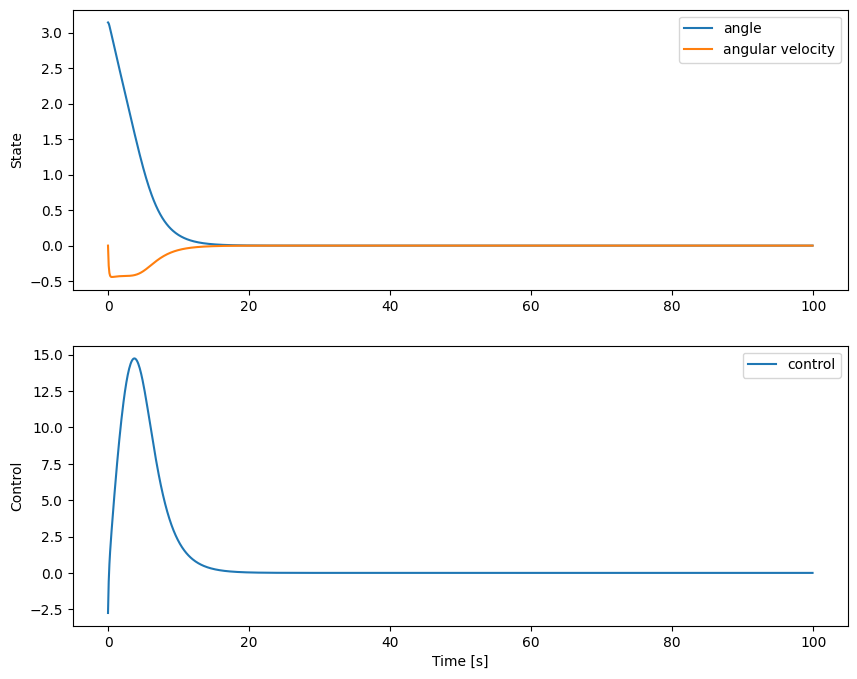

In [24]:
n_steps = 1000

for _ in range(n_steps):
    graph.step()

graph.reset()

## MPC control of the multiple envs

In [29]:
class ThreeWheeledRobotKinematic(Node):
    state = State("robot_state", (3,), np.array([5, -5, 0.8]))  # [x, y, angle]
    inputs = Inputs(["mpc_robot_state_control"])

    def __init__(self, is_root: bool = False, is_continuous: bool = True):
        super().__init__(is_root=is_root, is_continuous=is_continuous)
        self.action_bounds = {
            "mpc_robot_state_control": (
                np.array([-25.0, -5.0]),  # lower bounds
                np.array([25.0, 5.0]),  # upper bounds
            )
        }

    def system_dynamics(self, x: np.ndarray, u: np.ndarray):
        """Compute right-hand side of the dynamic system.

        Args:
            x: Current state [x, y, angle]
            u: Control inputs [velocity, angular_velocity]
        """
        Dstate = rg.zeros((3,), prototype=(x, u))

        # Kinematic model
        Dstate[0] = u[0] * rg.cos(x[2])  # dx/dt = v * cos(theta)
        Dstate[1] = u[0] * rg.sin(x[2])  # dy/dt = v * sin(theta)
        Dstate[2] = u[1]  # dtheta/dt = omega

        return {"robot_state": Dstate}

    def compute_state_dynamics(self):
        robot_control = self.inputs["mpc_robot_state_control"].data
        return self.system_dynamics(self.state.data, robot_control)
    

class Pendulum(Node):
    state = State("pendulum_state", (2,), np.array([np.pi, 0]))
    inputs = Inputs(["mpc_pendulum_state_control"])
    length = 1
    mass = 1
    gravity_acceleration = 9.81

    def system_dynamics(self, x, u):
        pendulum_mpc_control = u

        angle = x[0]
        angular_velocity = x[1]
        torque = pendulum_mpc_control

        d_angle = angular_velocity
        d_angular_velocity = (
            -3 * self.gravity_acceleration / (2 * self.length) * rg.sin(angle)
            + torque / self.mass
        )

        return {"pendulum_state": rg.vstack([d_angle, d_angular_velocity])}

    def compute_state_dynamics(self):
        pendulum_mpc_control = self.inputs["mpc_pendulum_state_control"].data

        return self.system_dynamics(self.state.data, pendulum_mpc_control)

In [30]:
class PlotDumper(Node):
    def __init__(self, **kwargs):
        state = State("plot_dumper", (1,), False)
        inputs = ["pendulum_state", "mpc_pendulum_state_control", "robot_state", "mpc_robot_state_control", "step_counter"]
        super().__init__(state=state, inputs=inputs, **kwargs)
        self.pendulum_states = []
        self.pendulum_controls = []
        self.robot_states = []
        self.robot_controls = []

    def compute_state_dynamics(self) -> Dict[str, Any]:
        self.pendulum_states.append(self.inputs["pendulum_state"].data)
        self.pendulum_controls.append(self.inputs["mpc_pendulum_state_control"].data)
        self.robot_states.append(self.inputs["robot_state"].data)
        self.robot_controls.append(self.inputs["mpc_robot_state_control"].data)

        if self.inputs["step_counter"].data[0] % 500 == 0:
            self._plot()
            self.pendulum_states = []
            self.pendulum_controls = []
            self.robot_states = []
            self.robot_controls = []

        return {self.state.name: False}

    def _plot(self) -> None:
        fig, axs = plt.subplots(4, 1, figsize=(10, 16))

        pendulum_states = np.array(self.pendulum_states)
        pendulum_controls = np.array(self.pendulum_controls)
        robot_states = np.array(self.robot_states)
        robot_controls = np.array(self.robot_controls)
        times = np.arange(len(pendulum_states)) * self.step_size

        axs[0].plot(times, pendulum_states[:, 0], label="Pendulum Angle")
        axs[0].set_ylabel("Pendulum Angle")
        axs[0].legend()

        axs[1].plot(times, pendulum_states[:, 1], label="Pendulum Angular Velocity")
        axs[1].set_ylabel("Pendulum Angular Velocity")
        axs[1].legend()

        axs[2].plot(times, robot_states[:, 0], label="Robot X Position")
        axs[2].plot(times, robot_states[:, 1], label="Robot Y Position")
        axs[2].set_ylabel("Robot Position")
        axs[2].legend()

        axs[3].plot(times, robot_states[:, 2], label="Robot Angle")
        axs[3].set_xlabel("Time [s]")
        axs[3].set_ylabel("Robot Angle")
        axs[3].legend()

        plt.tight_layout()
        plt.show()

In [31]:
pendulum = Pendulum(is_root=True, is_continuous=True)
robot = ThreeWheeledRobotKinematic(is_root=True, is_continuous=True)
mpc_pendulum_node = MPCNodeFactory(
    pendulum, control_shape=1, prediction_horizon=4, step_size=0.1
)
mpc_robot_node = MPCNodeFactory(
    robot, control_shape=2, prediction_horizon=4, step_size=0.1
)
plot_dumper = PlotDumper()
graph = Graph(
    [mpc_pendulum_node, pendulum, mpc_robot_node, robot, plot_dumper],
    states_to_log=[
        "pendulum_state",
        "mpc_pendulum_state_control",
        "step_counter",
        "robot_state",
        "mpc_robot_state_control",
    ],
    logger_cooldown=0.8,
)

Resolved node order: pendulum_state -> robot_state -> Clock -> step_counter -> mpc_pendulum_state_control -> mpc_robot_state_control -> plot_dumper -> Logger


2024-12-04 13:58:32,335 - t=0.100 | pendulum_state=[3.142 0.   ] | mpc_pendulum_state_control=-2.756 | step_counter=[1] | robot_state=[ 5.  -5.   0.8] | mpc_robot_state_control=[  2.343 -15.253]
2024-12-04 13:58:32,383 - t=0.600 | pendulum_state=[ 2.968 -0.441] | mpc_pendulum_state_control=2.847 | step_counter=[6] | robot_state=[-0.245 -0.765  0.016] | mpc_robot_state_control=[1.407 0.479]
2024-12-04 13:58:32,426 - t=1.200 | pendulum_state=[ 2.708 -0.436] | mpc_pendulum_state_control=6.480 | step_counter=[12] | robot_state=[-0.003 -0.753 -0.001] | mpc_robot_state_control=[0.008 0.018]
2024-12-04 13:58:32,461 - t=1.700 | pendulum_state=[ 2.494 -0.431] | mpc_pendulum_state_control=9.136 | step_counter=[17] | robot_state=[ 0.    -0.753 -0.   ] | mpc_robot_state_control=[-0.001  0.   ]
2024-12-04 13:58:32,489 - t=2.200 | pendulum_state=[ 2.281 -0.429] | mpc_pendulum_state_control=11.363 | step_counter=[22] | robot_state=[ 0.    -0.753  0.   ] | mpc_robot_state_control=[-0. -0.]
2024-12-04 

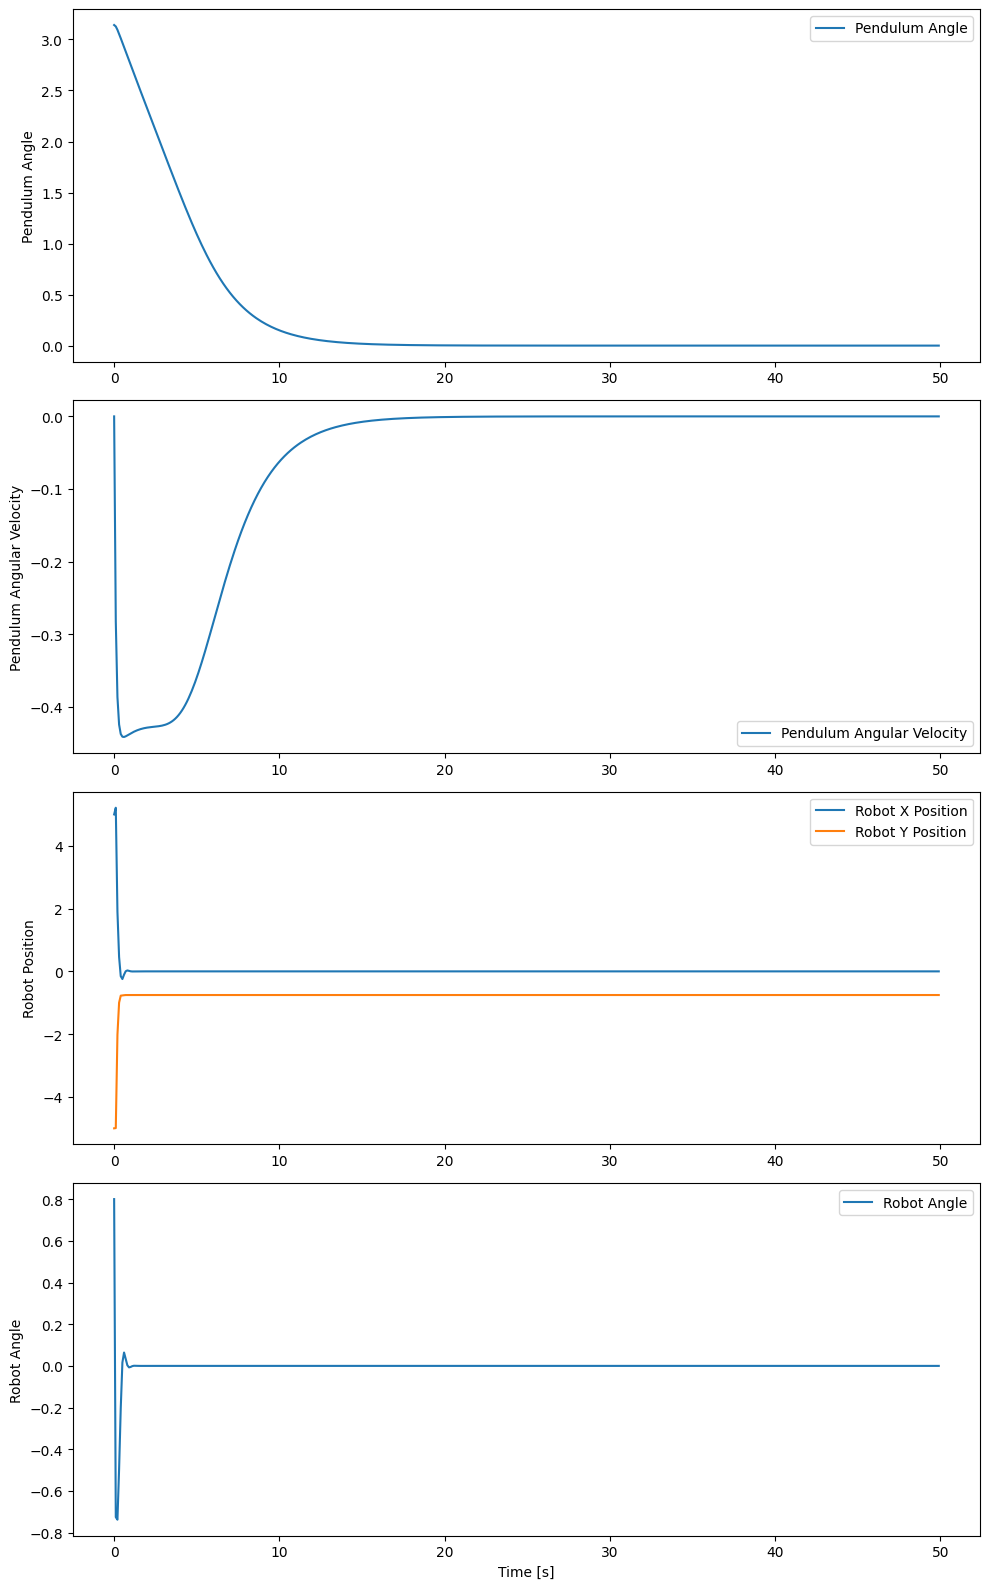

In [32]:
n_steps = 500

for _ in range(n_steps):
    graph.step()

graph.reset()

## Soft Actor Critic algorithm

# ![SAC|width=3.67%](./gfx/sac_algo.png)

# ![SAC MPC|width=3.67%](./gfx/sac.png)

In [13]:
class Pendulum(Node):
    state = State(
        "pendulum_state",
        (2,),
        np.array([np.pi, 0]),
        _reset_modifier=lambda x: np.array(
            [
                np.random.uniform(-np.pi, np.pi),
                np.random.uniform(-1.0, 1.0),
            ]
        ),
    )
    inputs = Inputs(["actor/action", "reset_pendulum_state"])
    length = 1
    mass = 1
    gravity_acceleration = 9.81

    def system_dynamics(self, x, u):
        pendulum_mpc_control = u

        angle = x[0]
        angular_velocity = x[1]
        torque = pendulum_mpc_control

        d_angle = angular_velocity
        d_angular_velocity = self.gravity_acceleration / self.length * rg.sin(
            angle
        ) + torque / (self.mass * self.length**2)

        return {"pendulum_state": rg.vstack([d_angle, d_angular_velocity])}

    def compute_state_dynamics(self):
        pendulum_mpc_control = self.inputs["actor/action"].data

        return self.system_dynamics(self.state.data, pendulum_mpc_control)

In [14]:
class Observer(Node):
    state = State("observation", (3,), np.zeros(3))
    inputs = ["pendulum_state"]

    cos_max = sin_max = 1.0
    max_speed = np.inf
    observation_high = np.array([cos_max, sin_max, max_speed], dtype=np.float32)
    observation_space = gym.spaces.Box(
        low=-observation_high, high=observation_high, dtype=np.float32
    )

    def compute_state_dynamics(self) -> Dict[str, Any]:
        angle, velocity = self.inputs["pendulum_state"].data
        x = np.cos(angle)
        y = np.sin(angle)
        return {"observation": np.array([x, y, velocity])}

In [15]:
class RewardComputer(Node):
    def __init__(self, step_size: float = 0.1):
        state = State("reward", (1,), np.zeros(1))
        inputs = ["observation", "actor/action"]
        super().__init__(step_size=step_size, state=state, inputs=inputs)

    def compute_state_dynamics(self) -> Dict[str, Any]:
        state = self.inputs["observation"].data
        action = self.inputs["actor/action"].data

        cos_angle, sin_angle, angular_velocity = state
        angle = np.arctan2(sin_angle, cos_angle)
        position_cost = 1 * angle**2
        velocity_cost = 0.1 * angular_velocity**2
        control_cost = 0.01 * (action**2)
        reward = -(position_cost + velocity_cost + control_cost)

        return {"reward": np.array([reward])}

In [16]:
class ActorNetwork(nn.Module):
    def __init__(
        self,
        action_space: gym.Space,
        observation_space: gym.Space,
        log_std_min: float = -5,
        log_std_max: float = 2,
    ):
        super().__init__()
        self.fc1 = nn.Linear(np.array(observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (action_space.high - action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (action_space.high + action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = self.log_std_min + 0.5 * (self.log_std_max - self.log_std_min) * (
            log_std + 1
        )  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean
    

class SoftQNetwork(nn.Module):
    def __init__(self, observation_space: gym.Space, action_space: gym.Space):
        super().__init__()
        self.fc1 = nn.Linear(
            np.array(observation_space.shape).prod()
            + np.array(action_space.shape).prod(),
            256,
        )
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
class Actor(Node):
    action_shape = (1,)
    max_torque = 2.0
    action_space = gym.spaces.Box(
        low=-max_torque, high=max_torque, shape=action_shape, dtype=np.float32
    )

    def __init__(
        self,
        step_size: float = 0.01,
        device="cpu",
        learning_starts: int = 5000,
    ):
        state = State(
            "actor",
            _value=[
                State("action", shape=self.action_shape),
                State(
                    "net",
                    _value=ActorNetwork(
                        action_space=self.action_space,
                        observation_space=Observer.observation_space,
                    ).to(device),
                ),
            ],
        )
        self.device = device
        inputs = Inputs(["observation", "step_counter"])
        self.learning_starts = learning_starts
        super().__init__(step_size=step_size, state=state, inputs=inputs)

    def compute_state_dynamics(self) -> Dict[str, Any]:
        if self.inputs["step_counter"].data < self.learning_starts:
            return {"actor/action": self.action_space.sample()}
        observation = (
            torch.FloatTensor(self.inputs["observation"].data)
            .reshape(1, -1)
            .to(self.device)
        )
        with torch.no_grad():
            action, _, _ = self.state["actor/net"].data.get_action(observation)
        return {"actor/action": action.cpu().numpy().reshape(-1)}

In [18]:
class Buffer(Node):
    def __init__(self, buffer_size: int = int(1e6), device: str = "cpu", **kwargs):

        self.buffer = ReplayBuffer(
            buffer_size=buffer_size,
            observation_space=Observer.observation_space,
            action_space=Actor.action_space,
            device=device,
            handle_timeout_termination=False,
        )
        state = State("replay_buffer", None, self.buffer)
        inputs = ["observation", "actor/action", "reward"]
        super().__init__(state=state, inputs=inputs, **kwargs)

        # Initialize replay buffer

        self.prev_obs = None

    def compute_state_dynamics(self) -> Dict[str, Any]:
        obs = self.inputs["observation"].data.reshape(1, -1)
        action = self.inputs["actor/action"].data.reshape(1, -1)
        reward = self.inputs["reward"].data.reshape(1, -1)
        replay_buffer: ReplayBuffer = self.state["replay_buffer"].data
        if self.prev_obs is not None:
            # Add transition to buffer
            replay_buffer.add(
                obs=self.prev_obs,
                next_obs=obs,
                action=action,
                reward=reward,
                done=np.array([False]),
                infos={},
            )

        self.prev_obs = obs
        return {}

In [19]:
class AdaptationBlock(Node):

    def __init__(
        self,
        learning_starts: int = 5000,
        device: str = "cpu",
        autotune: bool = False,
        policy_lr: float = 0.0003,
        q_lr: float = 0.0003,
        alpha: Optional[float] = None,
        batch_size: int = 256,
        gamma: float = 0.99,
        policy_frequency: int = 2,
        target_network_frequency: int = 2,
        tau: float = 0.005,
    ):
        state = State("adaptation_block_summary", _value={})
        inputs = Inputs(["actor/net", "step_counter", "replay_buffer"])
        super().__init__(state=state, inputs=inputs)

        self.learning_starts = learning_starts
        self.device = device
        self.qf1 = SoftQNetwork(
            observation_space=Observer.observation_space,
            action_space=Actor.action_space,
        ).to(device)
        self.qf2 = SoftQNetwork(
            observation_space=Observer.observation_space,
            action_space=Actor.action_space,
        ).to(device)
        self.qf1_target = SoftQNetwork(
            observation_space=Observer.observation_space,
            action_space=Actor.action_space,
        ).to(device)
        self.qf2_target = SoftQNetwork(
            observation_space=Observer.observation_space,
            action_space=Actor.action_space,
        ).to(device)
        self.qf1_target.load_state_dict(self.qf1.state_dict())
        self.qf2_target.load_state_dict(self.qf2.state_dict())
        self.q_optimizer = optim.Adam(
            list(self.qf1.parameters()) + list(self.qf2.parameters()), lr=q_lr
        )

        self.actor_optimizer = None

        self.batch_size = batch_size
        self.gamma = gamma
        self.policy_lr = policy_lr
        self.policy_frequency = policy_frequency
        self.target_network_frequency = target_network_frequency
        self.autotune = autotune
        self.tau = tau
        # Automatic entropy tuning
        if autotune:
            self.target_entropy = -torch.prod(
                torch.Tensor(Actor.action_space.shape).to(self.device)
            ).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha = self.log_alpha.exp().item()
            self.a_optimizer = optim.Adam([self.log_alpha], lr=q_lr)
        else:
            assert alpha is not None
            self.alpha = alpha

    def compute_state_dynamics(self):
        if self.actor_optimizer is None:
            self.actor_optimizer = optim.Adam(
                list(self.inputs["actor/net"].data.parameters()), lr=self.policy_lr
            )
        if self.inputs["step_counter"].data < self.learning_starts:
            return {}

        data = self.inputs["replay_buffer"].data.sample(self.batch_size)
        with torch.no_grad():
            next_state_actions, next_state_log_pi, _ = self.inputs[
                "actor/net"
            ].data.get_action(data.observations)
            qf1_next_target = self.qf1_target(
                data.next_observations, next_state_actions
            )
            qf2_next_target = self.qf2_target(
                data.next_observations, next_state_actions
            )
            min_qf_next_target = (
                torch.min(qf1_next_target, qf2_next_target)
                - self.alpha * next_state_log_pi
            )
            next_q_value = data.rewards.flatten() + (
                1 - data.dones.flatten()
            ) * self.gamma * (min_qf_next_target).view(-1)

        qf1_a_values = self.qf1(data.observations, data.actions).view(-1)
        qf2_a_values = self.qf2(data.observations, data.actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)
        qf2_loss = F.mse_loss(qf2_a_values, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        # optimize the model
        self.q_optimizer.zero_grad()
        qf_loss.backward()
        self.q_optimizer.step()

        if self.inputs["step_counter"].data % self.policy_frequency == 0:
            for _ in range(self.policy_frequency):
                pi, log_pi, _ = self.inputs["actor/net"].data.get_action(
                    data.observations
                )
                qf1_pi = self.qf1(data.observations, pi)
                qf2_pi = self.qf2(data.observations, pi)
                min_qf_pi = torch.min(qf1_pi, qf2_pi)
                actor_loss = ((self.alpha * log_pi) - min_qf_pi).mean()

                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                if self.autotune:
                    with torch.no_grad():
                        _, log_pi, _ = self.inputs["actor/net"].data.get_action(
                            data.observations
                        )
                    alpha_loss = (
                        -self.log_alpha.exp() * (log_pi + self.target_entropy)
                    ).mean()

                self.a_optimizer.zero_grad()
                alpha_loss.backward()
                self.a_optimizer.step()
                self.alpha = self.log_alpha.exp().item()

        if self.inputs["step_counter"].data % self.target_network_frequency == 0:
            for param, target_param in zip(
                self.qf1.parameters(), self.qf1_target.parameters()
            ):
                target_param.data.copy_(
                    self.tau * param.data + (1 - self.tau) * target_param.data
                )
            for param, target_param in zip(
                self.qf2.parameters(), self.qf2_target.parameters()
            ):
                target_param.data.copy_(
                    self.tau * param.data + (1 - self.tau) * target_param.data
                )
        return {}

In [20]:
class PlotObservations(Node):
    def __init__(self, plot_dir: str = "plots"):
        state = State("plot_counter", (1,), np.array([0]))
        inputs = ["observation", "is_truncated", "step_counter"] 
        super().__init__(state=state, inputs=inputs)
        self.observations = []

    def compute_state_dynamics(self) -> Dict[str, Any]:
        obs = self.inputs["observation"].data
        is_truncated = self.inputs["is_truncated"].data
        step = self.inputs["step_counter"].data[0]

        self.observations.append(obs)

        if is_truncated:
            import matplotlib.pyplot as plt
            plt.clf() # Clear current figure
            clear_output()
            observations = np.array(self.observations)
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

            # Plot cos(theta)
            ax1.plot(observations[:, 0], label="cos(θ)")
            ax1.set_ylabel("cos(θ)")
            ax1.grid(True)
            ax1.legend()

            # Plot sin(theta)
            ax2.plot(observations[:, 1], label="sin(θ)")
            ax2.set_ylabel("sin(θ)")
            ax2.grid(True)
            ax2.legend()

            # Plot angular velocity
            ax3.plot(observations[:, 2], label="ω")
            ax3.set_xlabel("Step")
            ax3.set_ylabel("Angular Velocity")
            ax3.grid(True)
            ax3.legend()

            plt.tight_layout()
            plt.show()
            plt.close('all') # Close all figures

            self.observations = []
            return {"plot_counter": self.state.data + 1}

        return {}

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_timesteps: int = 1000000
gamma: float = 0.99
"""the discount factor gamma"""
tau: float = 0.005
"""target smoothing coefficient (default: 0.005)"""
batch_size: int = 256
"""the batch size of sample from the reply memory"""
learning_starts: int = 5e3
"""timestep to start learning"""
policy_lr: float = 3e-4
"""the learning rate of the policy network optimizer"""
q_lr: float = 1e-3
"""the learning rate of the Q network network optimizer"""
policy_frequency: int = 2
"""the frequency of training policy (delayed)"""
target_network_frequency: int = 1  # Denis Yarats' implementation delays this by 2.
"""the frequency of updates for the target nerworks"""
alpha: float = 0.2
"""Entropy regularization coefficient."""
autotune: bool = True
"""automatic tuning of the entropy coefficient"""

'automatic tuning of the entropy coefficient'

In [22]:
pendulum = Pendulum(is_root=True, is_continuous=True)
observer = Observer()
actor = Actor(step_size=0.05, device=device, learning_starts=learning_starts)
is_truncated = IsTruncated(steps_to_truncate=200)
reset = Reset(input_node=pendulum)
reward_computer = RewardComputer()
buffer = Buffer(device=device)
adaptation_block = AdaptationBlock(
    gamma=gamma,
    tau=tau,
    batch_size=batch_size,
    learning_starts=learning_starts,
    policy_lr=policy_lr,
    q_lr=q_lr,
    policy_frequency=policy_frequency,
    target_network_frequency=target_network_frequency,
    alpha=alpha,
    autotune=autotune,
    device=device,
)
plot_observations = PlotObservations()

graph = Graph(
    nodes=[
        pendulum,
        observer,
        actor,
        is_truncated,
        reset,
        reward_computer,
        buffer,
        adaptation_block,
        plot_observations,
    ],
    states_to_log=[
        "pendulum_state",
        "observation",
        "is_truncated",
        "step_counter",
    ],
    logger_cooldown=0.5,
)

Resolved node order: pendulum_state -> Clock -> step_counter -> observation -> is_truncated -> actor -> reset_pendulum_state -> plot_counter -> Logger -> reward -> replay_buffer -> adaptation_block_summary


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

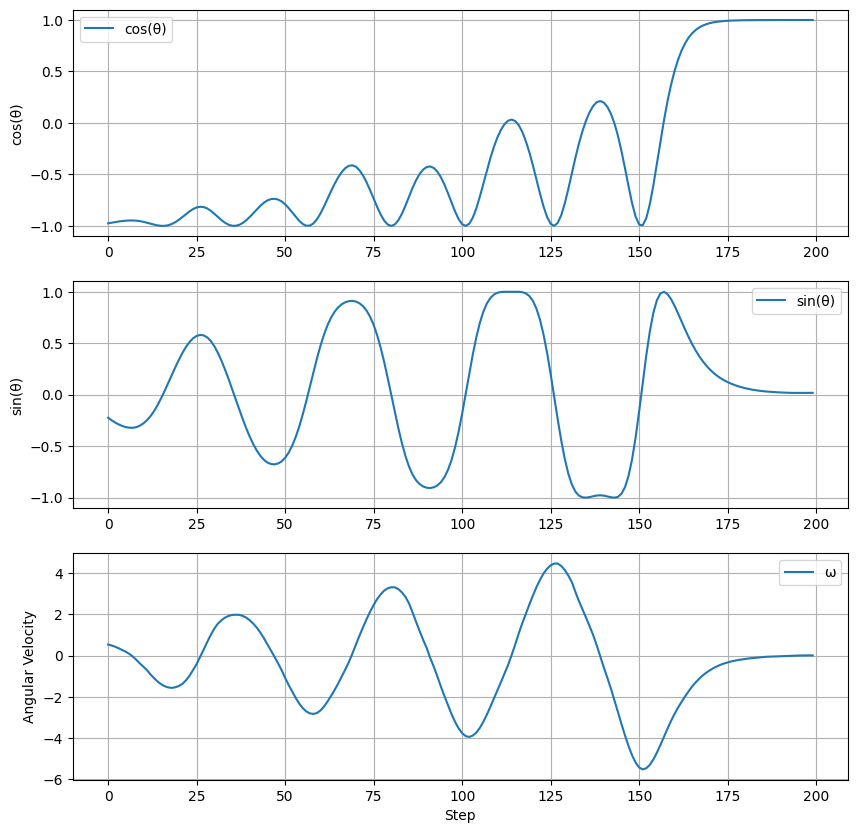

In [23]:
for _ in range(total_timesteps):
    graph.step()

graph.reset()